In [45]:
import torch
import torch.nn as nn
import random
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn.functional as F

import pandas as pd
import os
from collections import defaultdict
import wandb

In [28]:
def build_people_dict(csv_path, root_dir):
    """
    csv_path: path to 'peopleDevTrain.csv' or 'peopleDevTest.csv'
    root_dir: path to the folder containing the LFW subdirectories,
              e.g. 'lfw-deepfunneled'
    
    Returns: dict { person_name : [list_of_full_image_paths] }
    """
    df = pd.read_csv(csv_path)

    people_dict = defaultdict(list)
    
    for idx, row in df.iterrows():
        person_name = row['name']
        num_images_expected = row['images']
        
        # Get full folder path
        person_folder = os.path.join(root_dir, person_name)
        
        if os.path.exists(person_folder):
            # List all image files in this folder
            file_extensions = ('.jpg', '.jpeg', '.png')
            image_files = []
            for file in os.listdir(person_folder):
                if file.endswith(file_extensions):
                    image_files.append(file)
                image_files = sorted(image_files)
    
    
                # Build the full paths
                full_paths = [
                    os.path.join(person_folder, img_file) for img_file in image_files
                ]
                
                people_dict[person_name].extend(full_paths)
        else:
            print(f"No folder found for person: {person_name}")
    
    return dict(people_dict)

In [29]:
train_csv = "/home/user/javeda1/lwf_dataset/peopleDevTrain.csv"
test_csv = "/home/user/javeda1/lwf_dataset/peopleDevTest.csv"
root_dir = "/home/user/javeda1/lwf_datasets"  # Folder containing subfolders named after each person

people_dict_train = build_people_dict(train_csv, root_dir)
people_dict_test = build_people_dict(test_csv, root_dir)

In [31]:
class LFWTripletPeopleDataset(Dataset):
    def __init__(self, people_dict, transform=None, num_samples=10000):
        self.people_dict = people_dict
        self.person_ids = list(people_dict.keys())
        self.transform = transform
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Sample a random person for the anchor
        anchor_person = random.choice(self.person_ids)
        # 2) Sample two distinct images of this person: anchor and positive
        if len(self.people_dict[anchor_person]) < 2:
            # Resample: If there's only one image, we can't form a proper anchor-positive.
            return self.__getitem__(random.randint(0, self.num_samples-1))
        
        anchor_path, positive_path = random.sample(self.people_dict[anchor_person], 2)
        
        # 3) Sample a different person for the negative
        negative_person = random.choice(self.person_ids)
        while negative_person == anchor_person or len(self.people_dict[negative_person]) < 1:
            negative_person = random.choice(self.person_ids)
        negative_path = random.choice(self.people_dict[negative_person])
        
        # 4) Load images
        anchor_img = Image.open(anchor_path).convert("RGB")
        positive_img = Image.open(positive_path).convert("RGB")
        negative_img = Image.open(negative_path).convert("RGB")

        # 5) Transforms
        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        return anchor_img, positive_img, negative_img

In [32]:
train_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])

test_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])

In [33]:
# Create the Datasets
train_dataset = LFWTripletPeopleDataset(people_dict_train, transform=train_transform, num_samples=20000)
test_dataset = LFWTripletPeopleDataset(people_dict_test, transform=test_transform, num_samples=5000)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [37]:
def visualize_triplet_samples(dataset, n=5,
                              mean=(0.485, 0.456, 0.406),
                              std=(0.229, 0.224, 0.225)):
    """
    Visualize n samples (triplets) from the given TripletDataset.

    dataset: a dataset whose __getitem__(i) returns (anchor, positive, negative) each as a Tensor
    n: number of triplets to visualize
    mean, std: the normalization statistics used during training
               (ImageNet defaults shown)
    """

    # Define an "inverse" normalization transform to revert back to a displayable image
    inv_normalize = T.Compose([
        T.Normalize(mean=[0, 0, 0], std=[1/s for s in std]),
        T.Normalize(mean=[-m for m in mean], std=[1, 1, 1])
    ])

    fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(9, 3*n))

    for i in range(n):
        # Fetch one triplet
        anchor, positive, negative = dataset[i]

        # In case your dataset returns something else (e.g., also IDs), adapt accordingly.
        # For a standard triplet dataset, you have 3 tensors.

        # Undo normalization for display
        anchor_disp   = inv_normalize(anchor)
        positive_disp = inv_normalize(positive)
        negative_disp = inv_normalize(negative)

        # Convert to numpy arrays, clip to valid range [0, 1]
        anchor_np   = torch.clamp(anchor_disp, 0, 1).permute(1,2,0).cpu().numpy()
        positive_np = torch.clamp(positive_disp, 0, 1).permute(1,2,0).cpu().numpy()
        negative_np = torch.clamp(negative_disp, 0, 1).permute(1,2,0).cpu().numpy()

        # Plot
        axes[i, 0].imshow(anchor_np)
        axes[i, 1].imshow(positive_np)
        axes[i, 2].imshow(negative_np)
        
        axes[i, 0].set_title("Anchor")
        axes[i, 1].set_title("Positive")
        axes[i, 2].set_title("Negative")
        
        for j in range(3):
            axes[i, j].axis("off")

    plt.tight_layout()
    plt.show()

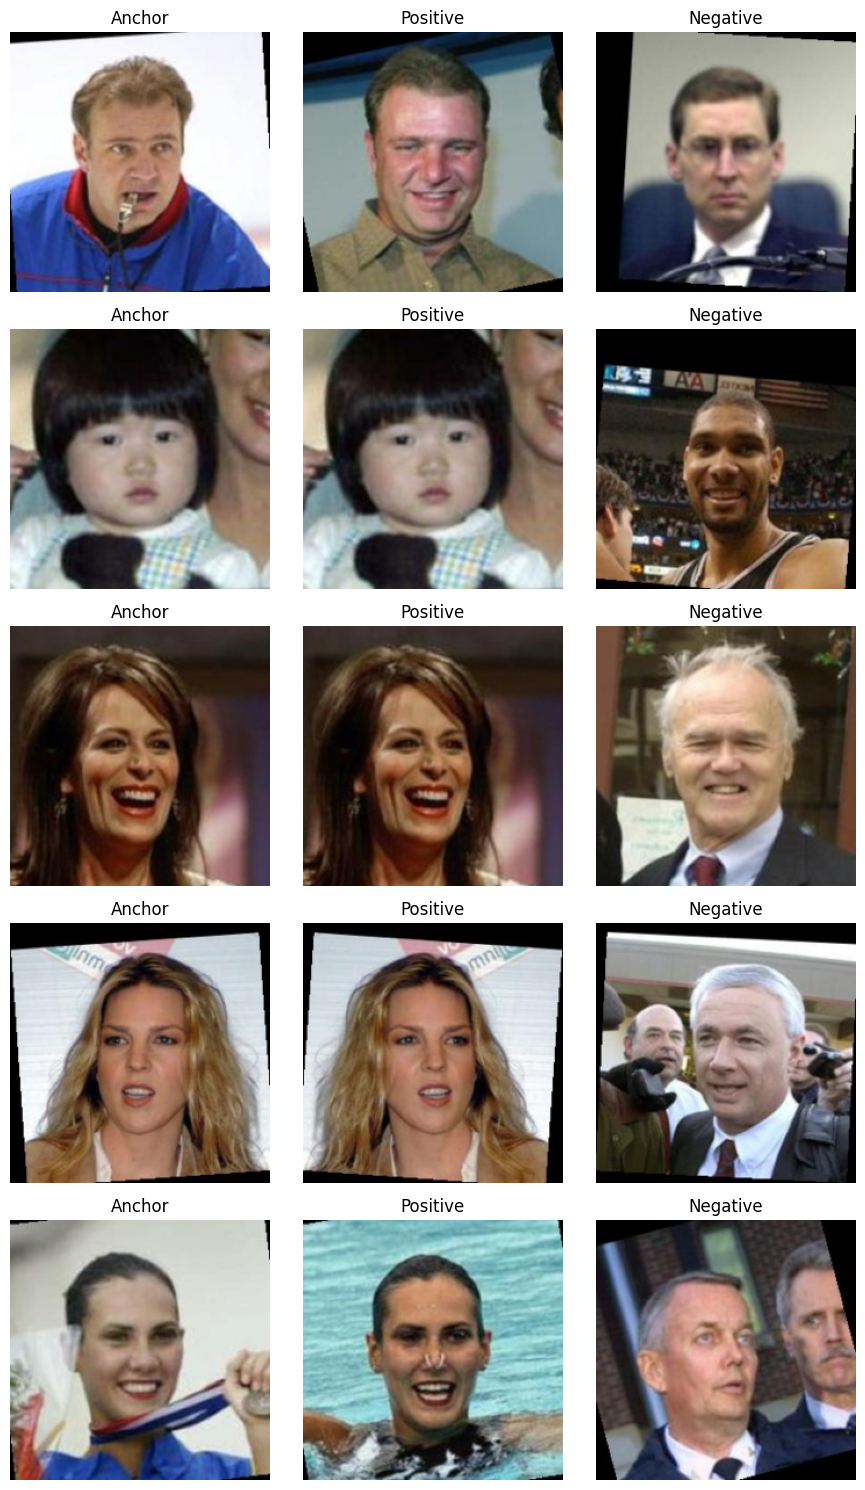

In [39]:
visualize_triplet_samples(train_dataset, n=5)

In [42]:
class TriNet(nn.Module):
    def __init__(self, embedding_dim=128):
        super(TriNet, self).__init__()
        # Load ResNet18
        self.resnet = models.resnet18(pretrained=True)
        # Remove the last FC
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])  
        # Now, self.resnet outputs a feature of size [batch, 512, 1, 1]
        
        # Define a new fully connected layer
        self.fc = nn.Linear(512, embedding_dim)

    def forward(self, x):
        # Extract features with the ResNet backbone
        x = self.resnet(x)  # [batch, 512, 1, 1]
        x = x.view(x.size(0), -1)  # Flatten to [batch, 512]
        
        # Get embedding
        x = self.fc(x)  # [batch, embedding_dim]
        
        # L2 normalize
        x = F.normalize(x, p=2, dim=1)  # [batch, embedding_dim]
        
        return x

In [48]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0
    
    for anchor, positive, negative in dataloader:
        anchor   = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)

        # Forward pass
        anchor_emb   = model(anchor)
        positive_emb = model(positive)
        negative_emb = model(negative)

        # Calculate loss
        loss = loss_fn(anchor_emb, positive_emb, negative_emb)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * anchor.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def eval_one_epoch(model, dataloader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for anchor, positive, negative in dataloader:
            anchor   = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            anchor_emb   = model(anchor)
            positive_emb = model(positive)
            negative_emb = model(negative)

            loss = loss_fn(anchor_emb, positive_emb, negative_emb)
            running_loss += loss.item() * anchor.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


def train(model, train_dataloader, val_dataloader, optimizer,
          device, epochs=10, margin=0.5,
         project="my_trinet-project", name='test_run-1'):
    """
    model: your neural network model
    train_dataloader, val_dataloader: DataLoaders returning (anchor, positive, negative, ...)
    optimizer: your PyTorch optimizer
    device: 'cpu' or 'cuda'
    epochs: number of epochs to train
    margin: margin for the TripletMarginLoss, user-defined

    This function initializes wandb, sets up the triplet loss using the margin, 
    and logs metrics (loss, learning rate) each epoch.
    """
    
    # Initialize Weights & Biases (adjust project/name as needed).
    # If you've already called wandb.init() before, remove or comment this line.
    wandb.init(project=project, name=name, config={
        "epochs": epochs,
        "margin": margin,
        "learning_rate": optimizer.param_groups[0]["lr"]
    })
    
    # Optionally watch the model (to log gradients, etc.):
    # wandb.watch(model, log="all")

    # Define the triplet loss with the user-specified margin
    triplet_loss_fn = nn.TripletMarginLoss(margin=margin, p=2)

    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_dataloader, optimizer, triplet_loss_fn, device)
        val_loss   = eval_one_epoch(model, val_dataloader, triplet_loss_fn, device)
        
        # Current learning rate (in case you're using schedulers or different param groups)
        current_lr = optimizer.param_groups[0]["lr"]

        # Log metrics to wandb
        wandb.log({
            "train_loss": train_loss,
            "val_loss": val_loss,
            "learning_rate": current_lr,
            "epoch": epoch + 1
        })

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {current_lr:.6f}")

    # Finish wandb run (optional, called automatically in many contexts)
    wandb.finish()

In [ ]:
# Example device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Suppose you have a TriNet model defined as:
# class TriNet(nn.Module): ...
model = TriNet(embedding_dim=128).to(device)

# Example optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Make sure you have your DataLoaders set up, e.g.:
# train_dataloader = ...
# val_dataloader = ...

# Now call the train function, specifying the number of epochs and the margin
train(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=test_loader,
    optimizer=optimizer,
    device=device,
    epochs=10,
    margin=0.5  # You can choose 0.2, 0.5, 1.0, etc.
)

/home/user/javeda1/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/javeda1/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
